### Bibliotecas

In [15]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.parallel
from torch import autograd
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torchvision.utils import make_grid
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader

import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

### Parâmetros

In [16]:
# Configuração para replicabilidade
torch.manual_seed(42)
np.random.seed(42)

num_epochs = 10
n_critic = 5
display_step = 300
log_interval = 100
batch_size = 64
lr = 0.0001

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

### Dataloader

In [17]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('../data/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label
    
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))      
])

dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Arquitetura de rede

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

### Definição dos modelos e seus otimizadores

In [19]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### Treinamento

Starting epoch 0...
g_loss: 4.254563331604004, d_loss: 0.617253303527832


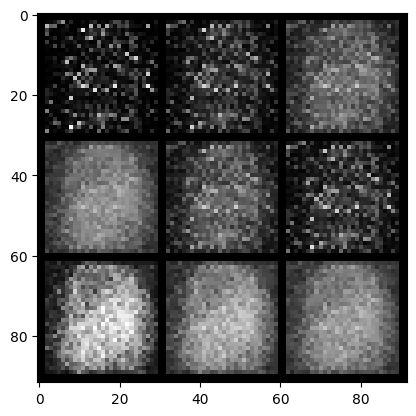

Starting epoch 1...
g_loss: 3.125213623046875, d_loss: 0.5858083963394165


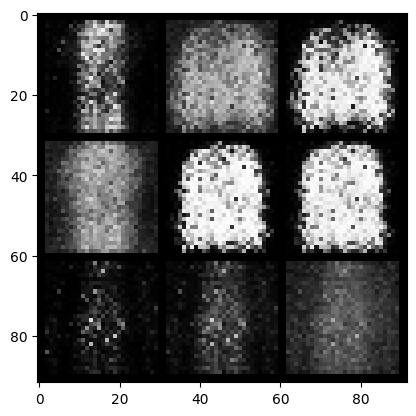

Starting epoch 2...
g_loss: 2.479135513305664, d_loss: 0.945271372795105


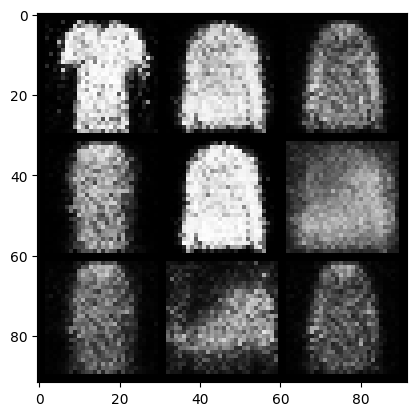

Starting epoch 3...
g_loss: 2.3361425399780273, d_loss: 0.5993982553482056


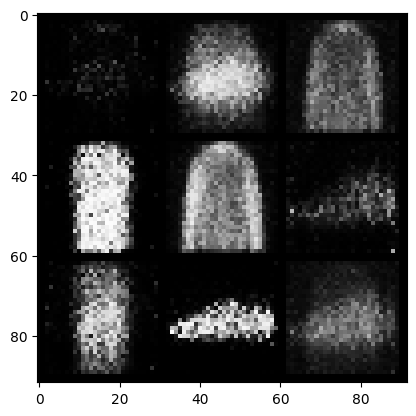

Starting epoch 4...
g_loss: 2.756117343902588, d_loss: 0.5112709403038025


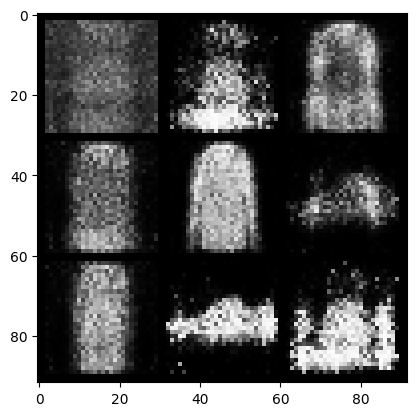

Starting epoch 5...
g_loss: 1.7424157857894897, d_loss: 0.5859472751617432


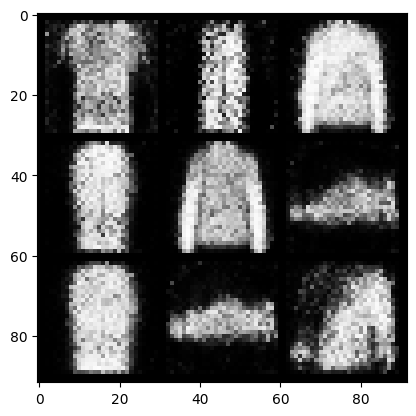

Starting epoch 6...
g_loss: 2.5154848098754883, d_loss: 1.0980615615844727


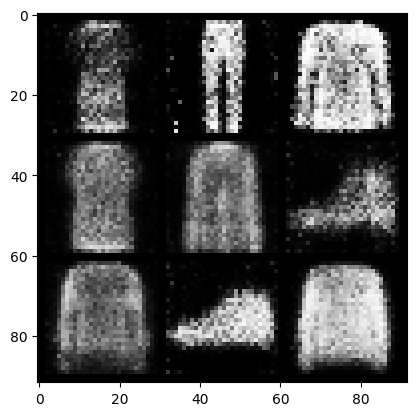

Starting epoch 7...
g_loss: 2.239274024963379, d_loss: 0.85334712266922


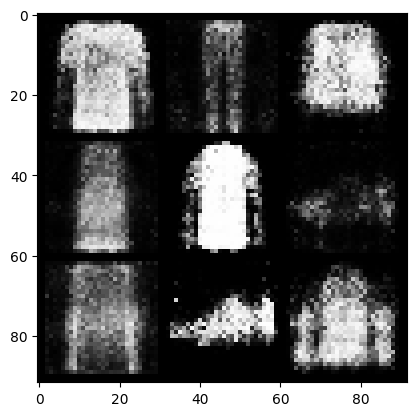

Starting epoch 8...
g_loss: 2.108769416809082, d_loss: 0.8124246001243591


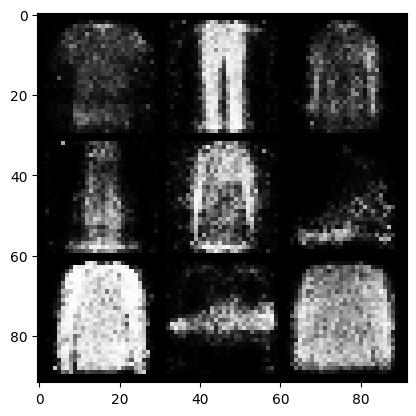

Starting epoch 9...
g_loss: 1.5179558992385864, d_loss: 0.8685640096664429


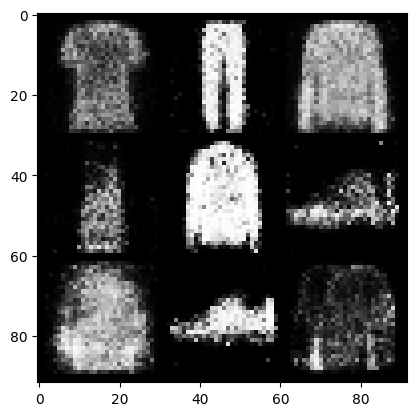

In [20]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

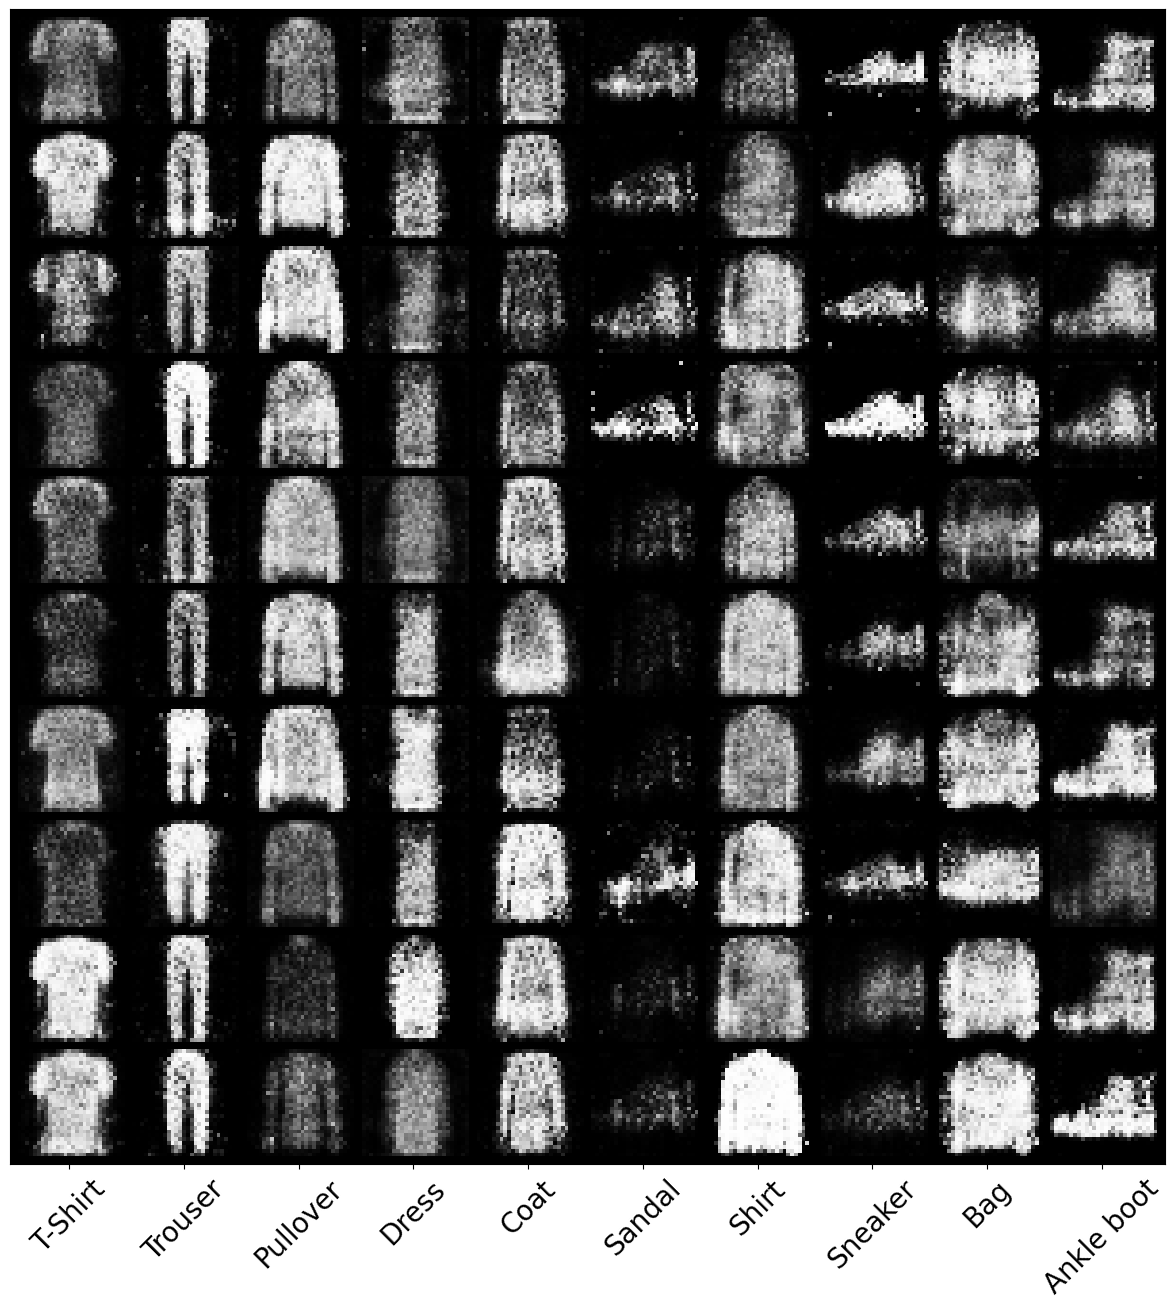

In [21]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)